# Open Exploration – Levers

Group 11, *EPA1361 Model-based Decision-making 18/19*

A. Werntges, H. Cheng, G. Papazotos, R. Patel, P. De Biase

## Summary

- **Dike heightening at all five locations** are the most powerful levers on expected damage and deaths,

   - Especially in Zutphen (A.3), Cortenoever (A.2) and Deventer (A.5) there are stricter requirements for dike height of at least 4.5 dm to avoid damage and deaths above a given threshold.


- **Early warning of evacuations** is also one of the most influential levers on reducing number of deaths.

- A higher investment costs (either by building dike or doing RfR) does NOT necessarily lead to less damage or deaths.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking, plotting)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

from model.problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)
np.random.seed(42)
random.seed(42)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


## 0 – Experiments

In this exploration over levers, we perform experiments for a two-timesteps dike model with the five-objectives problem formulation, i.e.

1. Expected annual damage
2. Dike investment costs
3. RfR investment costs
4. Evacuation costs
5. Expected number of deaths

The experiments are performed for 1,000 sampled policies, and per policy ten sampled scenarios. Both levers and uncertainties are done with LHS sampling.

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
ID_PF = 2    # assign problem_formulation_id
NR_STEPS = 2 # assign number of planning steps
dike_model, planning_steps = get_model_for_problem_formulation(ID_PF, NR_STEPS)

In [3]:
'''LOAD RESULTS FROM:
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=10, policies=1000) # using lhs sampling 
#
'''
results = load_results('./results/open_exploration_policies_10000runs_2steps.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_policies_10000runs_2steps.tar.gz


## 1 – The Outcomes: Boxplot and Pairwise Scatterplot

We first inspect the outcomes by boxplots and pairwise scatterplot. From the graphs we can see that the results for *Dike Investment Costs* and *RfR Investment Costs* are quite normally distributed. The outcomes of *Expected Annual Damage*, *Evacuation Costs* and *Expected Number of Deaths* are highly concentrated under some given thresholds with many "outliers" beyond the cap (Q3 + 1.5 * IQR). 

We can see from the pairwise scatterplots that the outcomes of *Expected Annual Damage*, *Expected Number of Deaths* and *Evacuation Costs*  are highly correlated to one another. We can also see from the graph that **a higher investment costs (either by building dike or doing RfR) does NOT necessarily lead to less damage or deaths**.

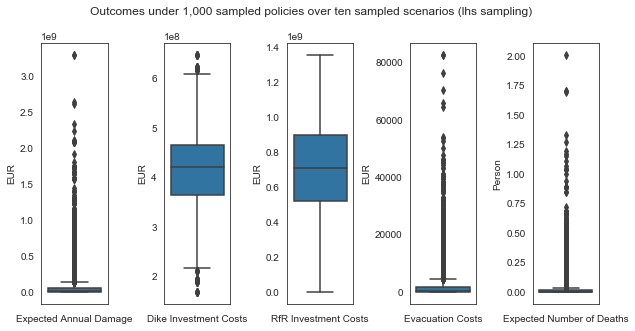

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
plt.subplots_adjust(wspace=0.85, top=0.85)
kpis = [key.name for key in dike_model.outcomes]
fig.suptitle('Outcomes under 1,000 sampled policies over ten sampled scenarios (lhs sampling)', 
             y=0.95, fontsize=12)

for key in kpis:
    sns.boxplot(pd.Series(outcomes[key]), orient='v',
                ax=axes[kpis.index(key)])
    axes[kpis.index(key)].set_xlabel(key)
    if 'Expected Number of Deaths' in key:
        axes[kpis.index(key)].set_ylabel('Person')
    else:
        axes[kpis.index(key)].set_ylabel('EUR')

In [9]:
YEARS = 100

# create a dataframe for outcomes with scenario annotated
outcomes_perScenario = pd.DataFrame.from_dict(outcomes)
outcomes_perScenario['Expected Total Damage'] = outcomes_perScenario['Expected Annual Damage']*YEARS
outcomes_perScenario['scenario'] = experiments.scenario

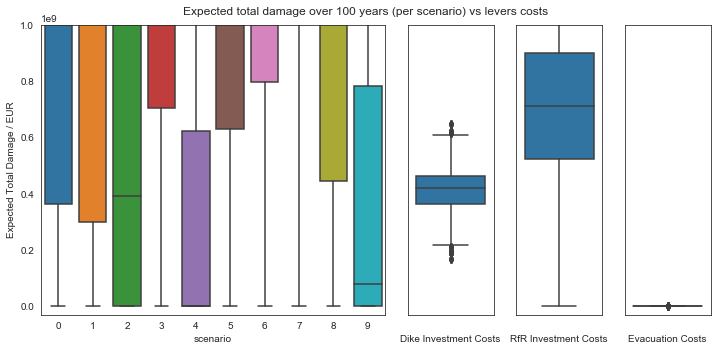

In [10]:
# check distribution of expected total damage per scenario vs levers costs
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[4, 1, 1, 1])

ax0 = plt.subplot(gs[0])
sns.boxplot(data=outcomes_perScenario, x='scenario', y='Expected Total Damage', fliersize=0.5, ax=ax0)
ax0.set_ylabel('Expected Total Damage / EUR')
ax0.set_ybound(-3e7, 1e9) # zoom-in for better visuals

kpis = ['Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs'] # levers costs

for kpi in kpis:
    ax = plt.subplot(gs[1+kpis.index(kpi)])
    ax = sns.boxplot(outcomes_perScenario[kpi], orient='v')
    ax.set_ylim(ax0.get_ylim())
    ax.set_xlabel(kpi)
    ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.15, top=0.93)
fig.suptitle('Expected total damage over {} years (per scenario) vs levers costs'.format(YEARS))
fig.align_xlabels()

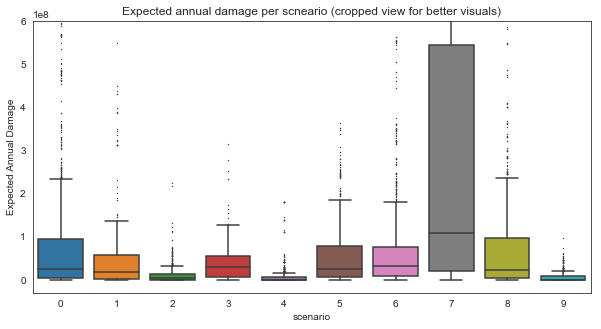

In [11]:
# check distribution of expected annual damage per scenario
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=outcomes_perScenario, x='scenario', y='Expected Annual Damage', fliersize=0.5)
ax.set_title('Expected annual damage per scneario (cropped view for better visuals)')
ax.set_ybound(-3e7, 6e8) # zoom-in for better visuals

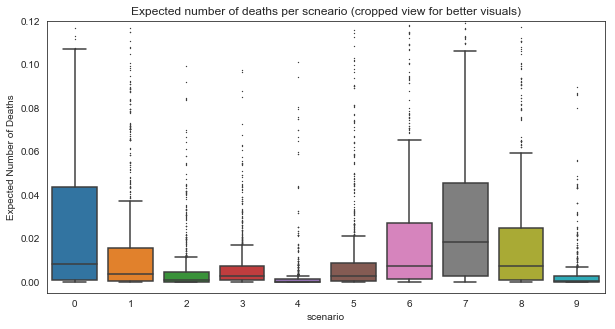

In [35]:
# check distribution of expected number of deaths per scenario
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=outcomes_perScenario, x='scenario', y='Expected Number of Deaths', fliersize=0.5)
ax.set_title('Expected number of deaths per scneario (cropped view for better visuals)')
ax.set_ybound(-0.005, 0.12) # zoom-in for better visuals

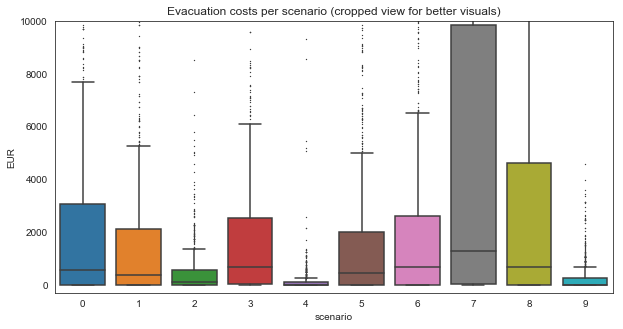

In [36]:
# check distribution of evacuation costs per scenario
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=outcomes_perScenario, x='scenario', y='Evacuation Costs', fliersize=0.5)
ax.set_title('Evacuation costs per scenario (cropped view for better visuals)')
ax.set_ylabel('EUR')
ax.set_ybound(-3e2, 1e4) # zoom-in for better visuals

### *Pairwise scatterplot*

[MainProcess/INFO] no time dimension found in results


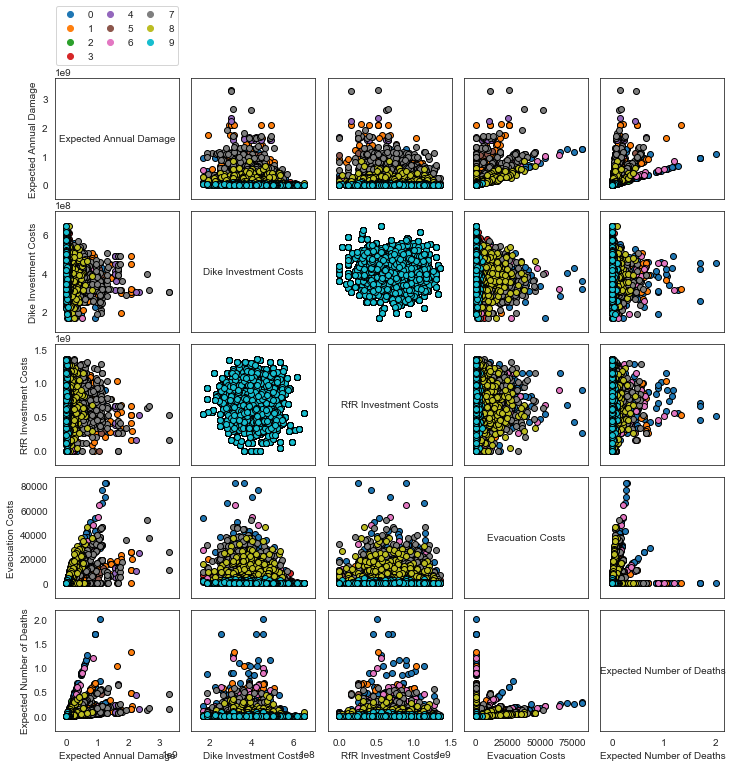

In [14]:
fig, ax = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='scenario', legend=True)
fig.set_size_inches([12, 12])

## 2 – Feature scoring

We then perform feature scoring for all outcomes to find out on which outcome does which lever has the largest influence.

From the results, we see that *Expected Annual Damage* is primarily influenced by **dike heightening at Zutphen (A.3)**, while RfR at Doesburg (A.1), Cortenover (A.2) and Deventer (A.5) seem to have very limited influence on the outcome of expected damage.

*Total Investment Costs* is most influenced by the **RfR levers at Cortenover (A.2) and Deventer (A.5)**.

The *Expected Number of Deaths* is also highly influenced by **dike heightening at Zutphen (A.3)** as well as the **evacuation** lever.

In [15]:
'''LOAD RESULTS FROM:
#
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=200, policies=200) # using lhs sampling
#
'''
results_200 = load_results('./results/open_exploration_uncertainties_40000runs_2steps.tar.gz')

experiments_200, outcomes_200 = results_200

[MainProcess/INFO] results loaded succesfully from D:\EPA\EPA Semester-1.4\EPA1361 Model-based Decision-making\MBDM-group-11\final assignment\results\open_exploration_uncertainties_40000runs_2steps.tar.gz


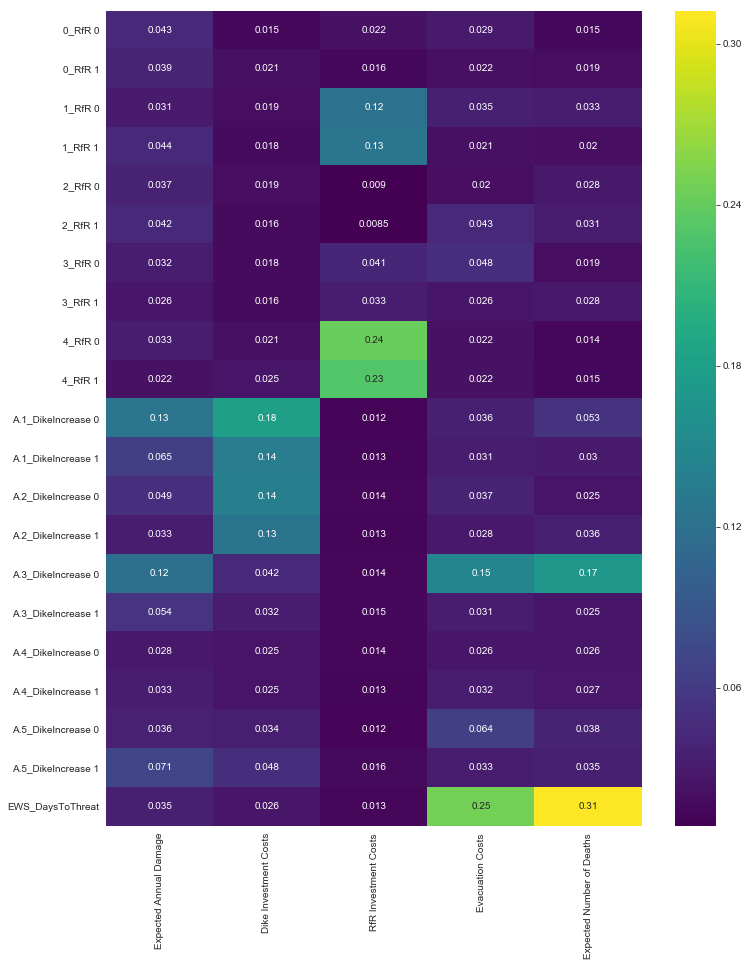

In [16]:
x = experiments_200.drop(columns = [u.name for u in dike_model.uncertainties]+['policy', 'model'])
y = outcomes_200

fs = feature_scoring.get_feature_scores_all(x, y, mode=RuleInductionType.REGRESSION)
plt.figure(figsize = (12,15))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

## 3 – Dimensional stacking & PRIM

We can further apply dimensional stacking to create a heatmap showing the influences of the most important levers, and PRIM to identify the range of those levers. We plot it for expected damage and number of deaths. 

### a. Expected Total Damage (over 200 years) < 3 billion EUR

The dimensional stacking plot shows that **the most powerful levers on expected damage are dike heightening at all five locations** with a min height of 3.5 ~ 6.5 dm, with Doesburg (A.1), the first municipality in the upstream, being an exception having a lower min height of 1.5 dm.

In [49]:
# threshold for subspace partitioning for damage
THRESHOLD_TOTAL_DAMAGE = 3e9
THRESHOLD_DAMAGE = THRESHOLD_TOTAL_DAMAGE / YEARS
print('Threshold for expected annual damage = {} million EUR'.format(int(THRESHOLD_DAMAGE/1e6)))

Threshold for expected annual damage = 30 million EUR


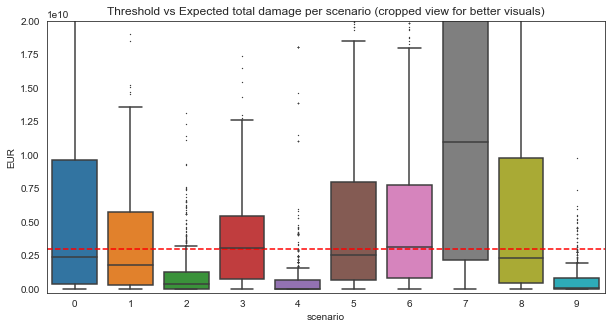

In [24]:
# check threshold vs distribution of expected total damage per scenario
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=outcomes_perScenario, x='scenario', y='Expected Total Damage', fliersize=0.5)
ax.hlines(THRESHOLD_TOTAL_DAMAGE, ax.get_xlim()[0], ax.get_xlim()[1], 
          colors='r', linestyles='--', lw=1.5)
ax.set_title('Threshold vs Expected total damage per scenario (cropped view for better visuals)')
ax.set_ylabel('EUR')
ax.set_ybound(-3e8, 2e10) # zoom-in for better visuals

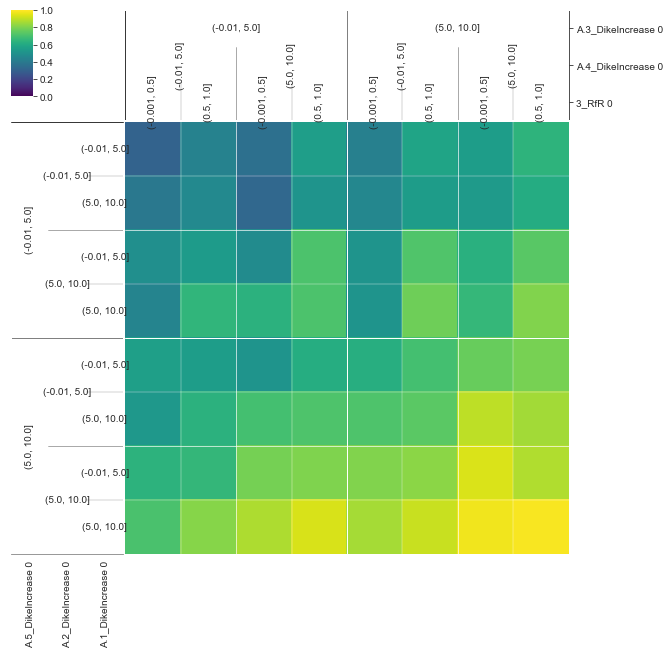

In [25]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy', 'model'])
y = outcomes['Expected Annual Damage'] < THRESHOLD_DAMAGE

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [26]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 10000 points remaining, containing 6302 cases of interest
[MainProcess/INFO] mean: 0.9803921568627451, mass: 0.051, coverage: 0.07933989209774675, density: 0.9803921568627451 restricted_dimensions: 5


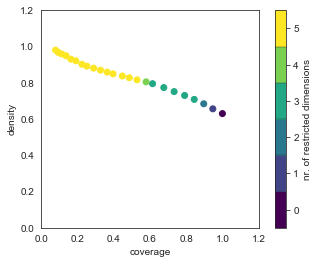

In [27]:
box1.show_tradeoff()
plt.show()

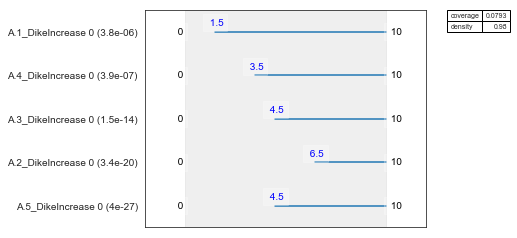

In [28]:
box1.inspect(style='graph')
plt.show()

### b. Expected Number of Deaths < 0.005 person

The dimensional stacking plot shows that **the most powerful levers on expected number of deaths are dike heightening at all five locations as well as early warning of evacuations**. Among the locations, dike heightening in Zutphen (A.3), Cortenoever (A.2) and Deventer (A.5) are the most influential on deaths and also have a stricter requirement on dike heights of 4.5 ~ 5.5 dm.

In [29]:
# threshold for subspace partitioning for deaths
THRESHOLD_DEATHS = 0.005

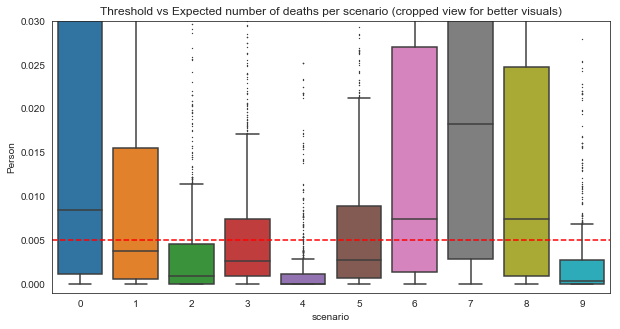

In [33]:
# check threshold vs distribution of expected annual damage per scneario
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=outcomes_perScenario, x='scenario', y='Expected Number of Deaths', fliersize=0.5)
ax.hlines(THRESHOLD_DEATHS, ax.get_xlim()[0], ax.get_xlim()[1], 
          colors='r', linestyles='--', lw=1.5)
ax.set_title('Threshold vs Expected number of deaths per scenario (cropped view for better visuals)')
ax.set_ylabel('Person')
ax.set_ybound(-0.001, 0.03) # futher zoom-in for better visuals

[MainProcess/INFO] model dropped from analysis because only a single category


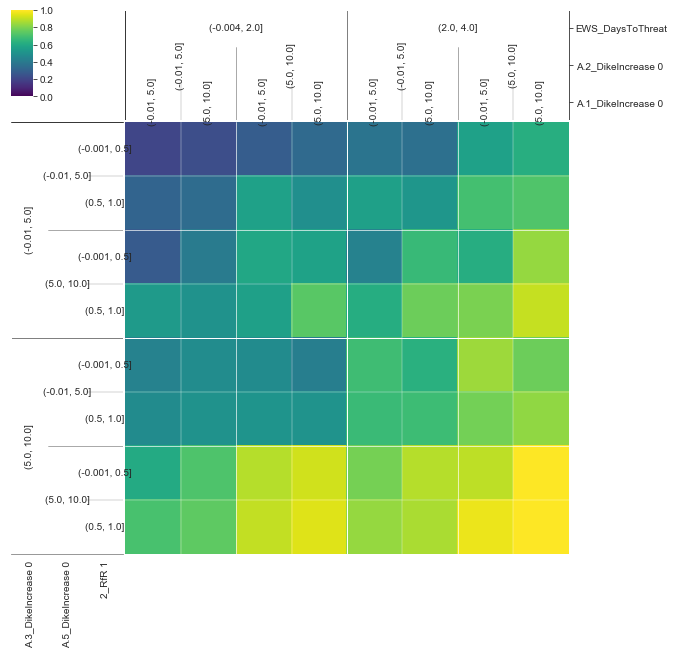

In [37]:
x = experiments.drop(columns = [u.name for u in dike_model.uncertainties]+['policy'])
y = outcomes['Expected Number of Deaths'] < THRESHOLD_DEATHS

dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2, bin_labels=True)
plt.show()

In [41]:
# PRIM
prim_alg = prim.Prim(x, y, threshold=0.8)
box2a = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 5899 cases of interest
[MainProcess/INFO] mean: 0.9941176470588236, mass: 0.051, coverage: 0.08594677063909137, density: 0.9941176470588236 restricted_dimensions: 7


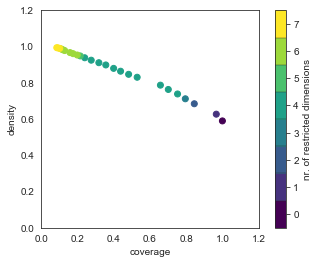

In [42]:
box2a.show_tradeoff()
plt.show()

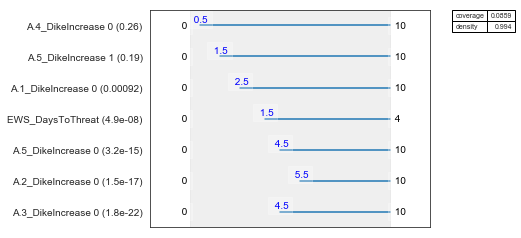

In [43]:
box2a.inspect(style='graph')
plt.show()

## Appendix

#### *The five sampled scenarios*

In [44]:
scenarios = experiments.loc[:, [u.name for u in dike_model.uncertainties]]
scenarios.drop_duplicates().T # transpose for seeing all scenarios

,0,1,2,3,4,5,6,7,8,9
discount rate 0,3.5,3.5,4.5,2.5,1.5,1.5,2.5,1.5,4.5,4.5
discount rate 1,3.5,2.5,1.5,3.5,4.5,4.5,4.5,1.5,1.5,2.5
A.0_ID flood wave shape,86,98,21,65,50,112,39,5,70,121
A.1_Bmax,144.902,91.1632,270.74,190.902,180.011,57.4081,321.112,242.412,297.266,105.489
A.1_pfail,0.858344,0.0543746,0.629196,0.434984,0.209741,0.366345,0.796514,0.152436,0.954103,0.546026
A.1_Brate,10,1,10,1,1,1.5,1.5,1.5,1,10
A.2_Bmax,152.438,96.8402,332.203,45.7007,272.684,84.3424,243.774,316.813,162.744,193.293
A.2_pfail,0.789119,0.223764,0.437692,0.676584,0.904241,0.167761,0.308779,0.0116571,0.578942,0.805356
A.2_Brate,1,1,1,10,10,1.5,1.5,1.5,10,1
A.3_Bmax,274.151,127.95,312.71,169.087,332.551,245.513,201.077,30.1711,123.495,69.3784
